In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
%matplotlib inline

from importlib import reload

from utils import saveVideo, show, drawShape

import laneFindingPipeline

In [2]:
reload(laneFindingPipeline)

<module 'laneFindingPipeline' from '/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py'>

In [3]:
undistort = laneFindingPipeline.Undistorter()

from glob import glob
undistort.fit(glob('camera_cal/*.jpg'))

A Jupyter Widget

In [4]:
# Load video
videoPrefix = 'project'
fpath = '%s_video.mp4' % videoPrefix
import skvideo.io

reader = skvideo.io.FFmpegReader(fpath)
frames = []
for (i, f) in enumerate(tqdm.tqdm_notebook(
    reader.nextFrame(), 
    total=reader.inputframenum,
)):
    frames.append(f)

A Jupyter Widget

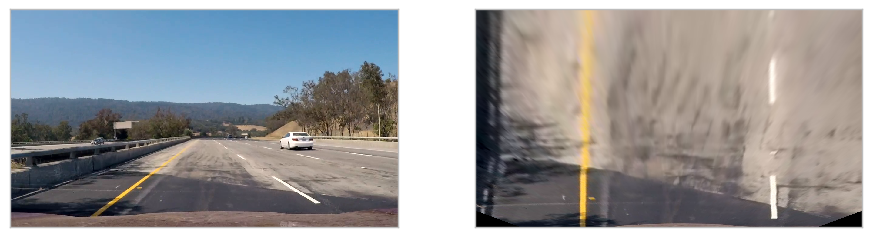

In [5]:
reload(laneFindingPipeline)
perspective = laneFindingPipeline.PerspectiveTransformer()
problemIndices = 298, 10, 550, 200, 612, 1000
frame = frames[problemIndices[2]]
warped = perspective(undistort(frame))

fig, (ax, bx) = plt.subplots(ncols=2)
show(frame, ax=ax);
show(warped, ax=bx);

In [6]:
def circleKernel(ksize):
    kernel = cv2.getGaussianKernel(ksize, 0)
    kernel = (kernel * kernel.T > kernel.min()/3).astype('uint8')
    return kernel
# show(circleKernel(5))

In [7]:
import skvideo.io

videoPrefices = ('project', 'challenge', 'harder_challenge')
allFrames = {}
for videoPrefix in videoPrefices:
    fpath = '%s_video.mp4' % videoPrefix
    reader = skvideo.io.FFmpegReader(fpath)
    frames = []
    for f in tqdm.tqdm_notebook(
        reader.nextFrame(), 
        total=reader.inputframenum,
        desc='load %s' % videoPrefix,
    ):
        frames.append(f)
    allFrames[videoPrefix] = frames

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [20]:
colorFilter = laneFindingPipeline.ColorFilter()
perspective = laneFindingPipeline.PerspectiveTransformer()

def equalizeHist(img):
    img = np.copy(img)
    for i in range(3):
        img[:, :, i] = cv2.equalizeHist(img[:, :, i])
    return img

def morphologicalSmoothing(img, ksize=10):
    # For binary images only.
    # Circular kernel:
    kernel = cv2.getGaussianKernel(ksize, 0)
    kernel * kernel.T > kernel.min() / 3
    # Close holes:
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Despeckle:
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

def uint8scale(vec, lo=0):
    vec = np.copy(vec)
    vec -= vec.min()
    if vec.max() != 0:
        vec /= vec.max()
    vec *= (255 - lo)
    vec += lo
    return vec.astype('uint8')

CPU times: user 2.99 s, sys: 2.12 s, total: 5.11 s
Wall time: 2.5 s


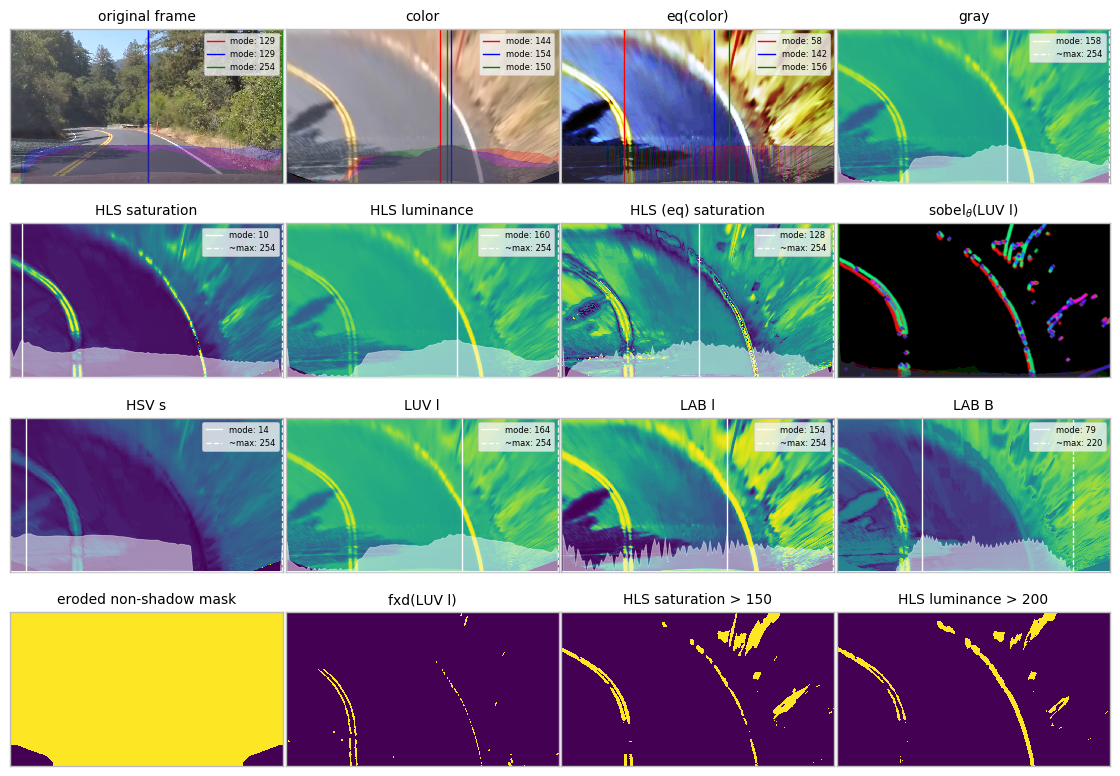

In [23]:
%%time
import utils
def show(img, ax, title=None, doLegend=True):
    ax.imshow(img)
    hi = img.shape[0]
    
    mono = len(img.shape) == 2
    
    if not len(set(img.ravel())) == 2:
        def hist(ichannel, color, heightFraction=.25, histAlpha=.5):
            if not mono:
                histAlpha /= 2
            data = np.copy(img.reshape((img.shape[0], img.shape[1], -1))[:, :, ichannel]).ravel()
            hist, bins = np.histogram(data, bins=128)
            bins = (bins[:-1] + bins[1:]) / 2.
            imax = np.argmax(hist)
            vmax = bins[imax]
            
            brightest = max(bins[hist/max(hist)>1e-4])
            
            hist = np.log10(hist + 1e-10)
            hist -= hist.min()
            hist = hist * img.shape[0] / hist.max() * heightFraction
            bins /= 255
            bins *= img.shape[1]
            ax.fill_between(bins, hi, hi-hist, alpha=histAlpha, color=color, zorder=999)
            ax.axvline(bins[imax], label='mode: %d' % vmax, color=color)
            if mono:
                
                ax.axvline(
                    brightest / 255 * img.shape[1], 
                    label='~max: %d' % brightest, color=color, linestyle='--'
                )
            
        if mono:
            hist(0, 'white')
        else:
            for i in range(3):
                hist(i, ['red', 'blue', 'green'][i])
        if doLegend: ax.legend(fontsize=6, loc='upper right')
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(hi, -1) 
    
    ax.set_title(title)
    return fig, ax

def plot(fig, axes, frame):
    fx = lambda bw: np.abs(cv2.Sobel(bw, cv2.CV_64F, 1, 0))
    fxd = colorFilter.dilateSobel

    img = perspective(undistort(frame))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    eq = equalizeHist(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    hls = cv2.cvtColor(eq, cv2.COLOR_RGB2HLS)
    lq_channel = hls[:, :, 1]
    sq_channel = hls[:, :, 2]
    
    lab = cv2.cvtColor(eq, cv2.COLOR_RGB2LAB)
    labl_channel = lab[:, :, 0]
    labb_channel = lab[:, :, 2]
    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    luvl_channel = luv[:, :, 0]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsvs_channel = hsv[:, :, 1]
    hsvh_channel = hsv[:, :, 0]

    # Erode a mask on light areas. This provides a mask
    # to exclude edges due to shadow.
    shadowMask = cv2.erode((gray > 16).astype('uint8'), circleKernel(10), iterations=15)

    dilate = lambda image, ksize=5, iterations=1: cv2.dilate(image, circleKernel(ksize), iterations=iterations)
#     grayFeatures = morphologicalSmoothing(shadowMask & fxd(gray))
#     bfeatures = fxd(b_channel)

    st = 150
    lt = 200
    
    r = 0
    c = 0
    ax = lambda : axes[r][c]
    
    show(frame, ax(), title='original frame'); c+= 1
    show(img, ax(), title='color'); c+= 1
    show(eq, ax(), title='eq(color)'); c+= 1
    show(gray, ax(), title='gray'); c+= 1
    #show(fx(gray), ax=axes[0][3], title='sobelx(gray)')
        
    c=0; r+= 1
    
    #show(h_channel, ax(), title='HLS hue'); c+= 1
    show(s_channel, ax(), title='HLS saturation'); c+= 1
    show(l_channel, ax(), title='HLS luminance'); c+= 1
    show(sq_channel, ax(), title='HLS (eq) saturation'); c+= 1
    #show(hsvh_channel, ax(), title='HSV h'); c+= 1
    #show(lq_channel, ax(), title='HLS (eq) luminance'); c+= 1
    #show(sobeltheta, ax(), title=r'sobel$_\theta$(LUV l)'); c+= 1
    #show(sobelx, ax(), title=r'sobel$_x$(LUV l)'); c+= 1
    #show(sobely, ax(), title=r'sobel$_y$(LUV l)'); c+= 1
    
    toSobel = (s_channel>st).astype('uint8')*255
    sobelx = dilate(cv2.Sobel(toSobel, cv2.CV_64F, 1, 0), iterations=4)
    sobely = dilate(cv2.Sobel(toSobel, cv2.CV_64F, 0, 1), iterations=4)
    sobelmag = np.log10(np.sqrt(sobelx ** 2 + sobely ** 2) + 1)
    sobeltheta = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    one = np.ones_like(sobeltheta, 'uint8')*240
    hue = uint8scale(sobeltheta)
    mag = uint8scale(sobelmag, lo=0)
    sobelhsv = np.dstack((hue, one, mag))
    show(
        cv2.GaussianBlur(
            cv2.cvtColor(sobelhsv, cv2.COLOR_HSV2RGB),
            (15, 15), 0
        ), 
        ax(), title=r'sobel$_\theta$(LUV l)', doLegend=False
    ); c+= 1
    
    c=0; r+= 1
    
    show(hsvs_channel, ax(), title='HSV s'); c+= 1
    show(luvl_channel, ax(), title='LUV l'); c+= 1
    show(labl_channel, ax(), title='LAB l'); c+= 1
    show(labb_channel, ax(), title='LAB B'); c+= 1
    
    c=0; r+= 1

    
    
    show(shadowMask, ax(), title='eroded non-shadow mask'); c+= 1
    #show(bfeatures, ax=axes[1][1], title='b features')
    #show(grayFeatures, ax=axes[1][2], title='gray features')
    #show(fxd(gray), ax=axes[1][3], title='sobelxDilate(gray)')
    show(fxd(luvl_channel), ax(), title='fxd(LUV l)'); c+= 1
    show(s_channel>st, ax(), title='HLS saturation > %s' % st); c+= 1
    show(l_channel>lt, ax(), title='HLS luminance > %s' % lt); c+= 1
    
    for r in axes:
        for ax in r:
            ax.title.set_fontsize(10)
            ax.set_xticks([])
            ax.set_yticks([])

    fig.subplots_adjust(bottom=0, left=0, right=1, top=.95, wspace=0.01, hspace=.1)

fa = lambda : plt.subplots(nrows=4, ncols=4)
fig, axes = fa()
plot(fig, axes, allFrames['harder_challenge'][42])
fig.savefig('doc/grid.png')

In [32]:
import utils
reload(utils)
reload(laneFindingPipeline)

<module 'laneFindingPipeline' from '/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py'>

In [24]:
maxframes = 320000
overallBar = tqdm.tqdm_notebook(
    total=sum([min(len(fr), maxframes) for fr in allFrames.values()]), 
    unit='frame', desc='%d videos' % len(allFrames)
)

for videoPrefix in videoPrefices:
    frames = allFrames[videoPrefix][:maxframes]
    
    def yieldPlots():

        fig, axes = fa()

        for frame in frames:
            overallBar.update()

            plot(fig, axes, frame)

            yield utils.fig2img(fig)

            for r in axes:
                for ax in r:
                    ax.cla()
                    
        fig.clf()

    utils.saveVideo(
        yieldPlots(), 'filterOptions-%s.mp4' % videoPrefix, 
        total=len(frames), desc=videoPrefix,
    )

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [33]:
channel = np.random.uniform(size=(720, 1280))

In [37]:
(channel > .5).sum()

459980

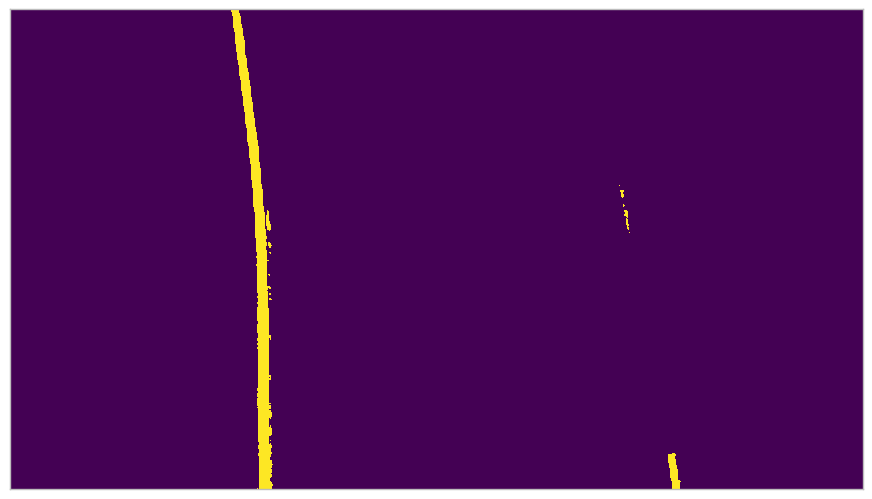

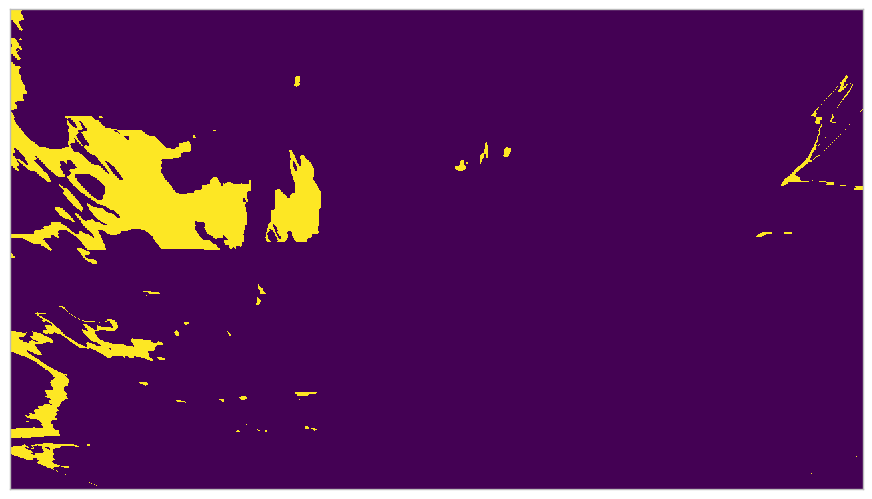

In [172]:
easyFrame = allFrames['project'][68]
hardFrame = allFrames['project'][1037]
def get_s(frame):
    img = perspective(undistort(frame))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    eq = equalizeHist(img)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:, :, 2]
#utils.show(hardFrame);
utils.show(get_s(easyFrame) > 150);
utils.show(get_s(hardFrame) > 254);

A Jupyter Widget

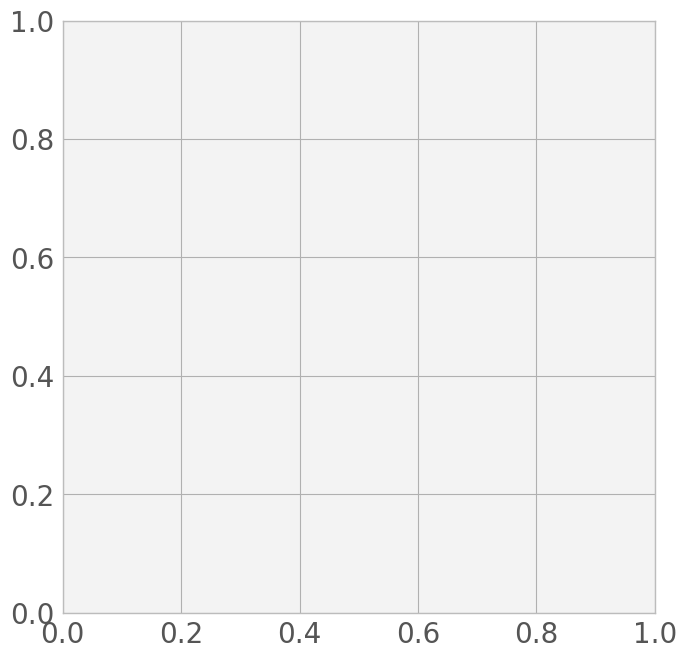

In [64]:
fig, ax = plt.subplots()
framesMax = 2000
counts = []
def yieldFrames():
    for frame in allFrames['project'][:framesMax]:
        thr = get_s(frame) > 150
        ct = thr.sum()
        counts.append(ct)
        utils.show(thr, ax=ax, title='%d pixels' % ct)
        yield utils.fig2img(fig)
        ax.cla()
vid = utils.saveVideo(yieldFrames(), 'thresholdCounts.mp4', total=framesMax)
fig.clf()
vid

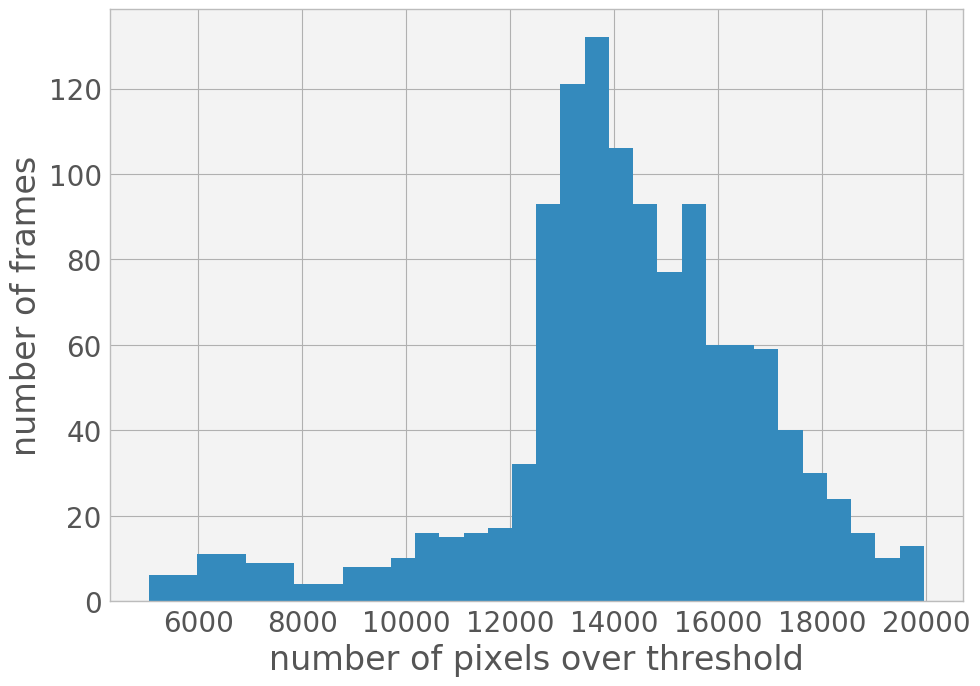

In [69]:
fig, ax = plt.subplots()
counts = np.array(counts)
ax.hist(counts[(counts < 20000) & (counts > 5000)], bins=32)
ax.set_xlabel('number of pixels over threshold')
ax.set_ylabel('number of frames');

In [173]:
class CountSeekingThreshold:
    
    def __init__(self, countBounds, initialThreshold=150):
        self.countBounds = countBounds
        self.threshold = initialThreshold
        self.lastthreshes = [initialThreshold, initialThreshold]
        self.iterationCounts = []
        
    def __call__(self, channel):
        
        def getCount(threshold):
            mask = channel > np.round(threshold)
            return mask, mask.sum()
        
        def bifurcationSearch(goalCount, threshold, countTol=200):
            under = 0
            over = 255
            getThreshold = lambda : (over - under) / 2 + under
            niter = 0
            while True:
                mask, count = getCount(threshold)
                if (
                    abs(count - goalCount) < countTol
                    or over - under <= 1
                ):
                    break
                
                if count > goalCount:
                    # Too many pixels got in; threshold needs to be higher.
                    under = threshold
                    threshold = getThreshold()
                else: # count < goalCout
                    if threshold > 254 and getCount(254)[1] > goalCount:
                        # In the special case that opening any at all is too bright, die early.
                        threshold = 255
                        mask = np.zeros_like(channel, 'bool')
                        break
                    over = threshold
                    threshold = getThreshold()
                niter += 1
                
            out =  max(min(int(np.round(threshold)), 255), 0)
            self.iterationCounts.append(niter)
            return mask, out
                    
        out = [
            bifurcationSearch(goalCount, lastthresh) 
            for goalCount, lastthresh in zip(self.countBounds, self.lastthreshes)
        ]
        self.lastthreshes = out[0][1], out[1][1]
        return out
    
countSeekingThreshold = CountSeekingThreshold((8000, 13000))
for frame in easyFrame, hardFrame:
    (himask, hithresh), (lomask, lothresh) = countSeekingThreshold(get_s(frame))
    print(lothresh, hithresh)

145 199
255 255


In [174]:
fig, (ax, bx) = plt.subplots(ncols=2)
frames = allFrames['project']
frameIndices = list(range(len(frames)))[900:1100]
def yieldFrames():
    for i in frameIndices:
        frame = frames[i]
        (himask, hithresh), (lomask, lothresh) = countSeekingThreshold(get_s(frame))
        for mask, thresh, a in zip([himask, lomask], [hithresh, lothresh], [ax, bx]):
            ct = mask.sum()
            utils.show(mask, ax=a, title=r'%d: < %.4g $\rightarrow$ %d pts' % (i, thresh, ct))
            a.title.set_fontsize(10)
        yield utils.fig2img(fig)
        for a in ax, bx:
            a.cla()
vid = utils.saveVideo(yieldFrames(), 'thresholdSearch.mp4', total=len(frameIndices))
fig.clf()
vid

A Jupyter Widget

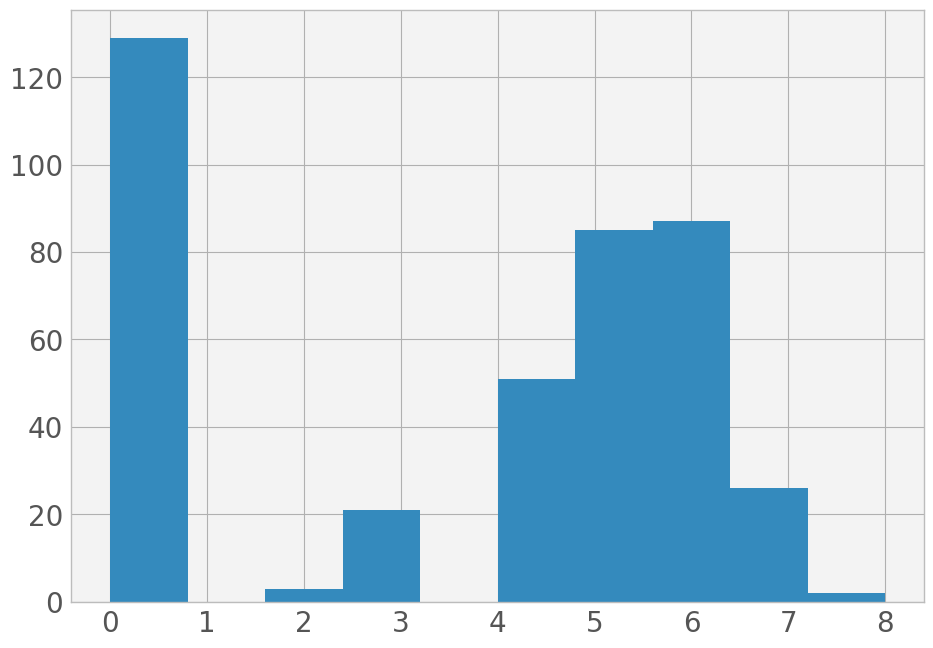

In [175]:
fig, ax = plt.subplots()
ax.hist(countSeekingThreshold.iterationCounts);

(<matplotlib.figure.Figure at 0x7fca53b23128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca423324a8>)

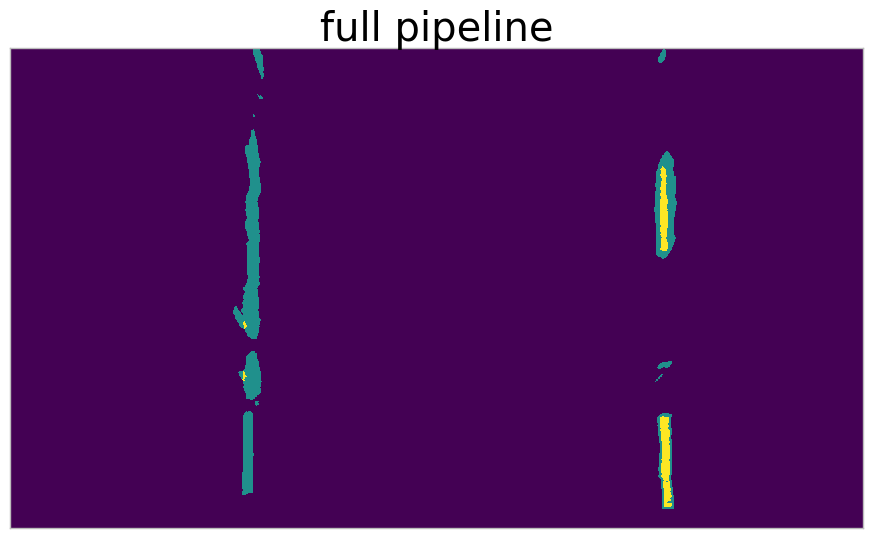

In [26]:
laneFinder = laneFindingPipeline.LaneFinder(undistort)
utils.show(laneFinder.preprocess(frame), title='full pipeline')

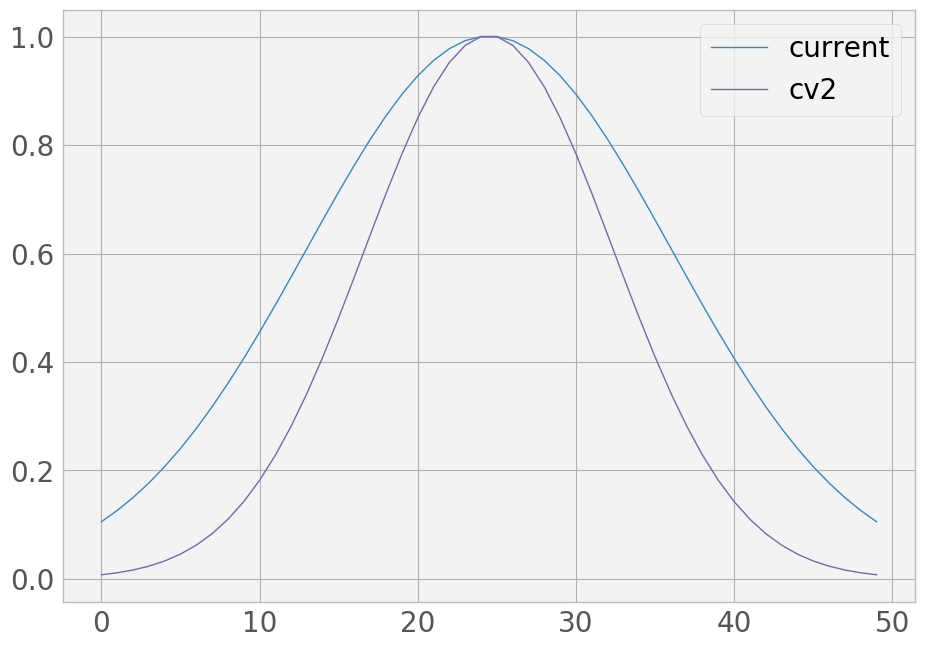

In [27]:
window_width = 50
radius = laneFinder.markingFinder.gaussianRadius
k = np.exp(-np.linspace(-radius, radius, window_width)**2)
plt.plot(k/k.max(), label='current')
k = cv2.getGaussianKernel(window_width, 0)
plt.plot(k/k.max(), label='cv2')
plt.legend()

How much of the lane's width does a typical 80-inch car take up?

In [28]:
laneOccupancyFraction = 2.032 / 3.7
laneOccupancyFraction

0.5491891891891891

(<matplotlib.figure.Figure at 0x7fca30da9c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca3df2b0f0>)

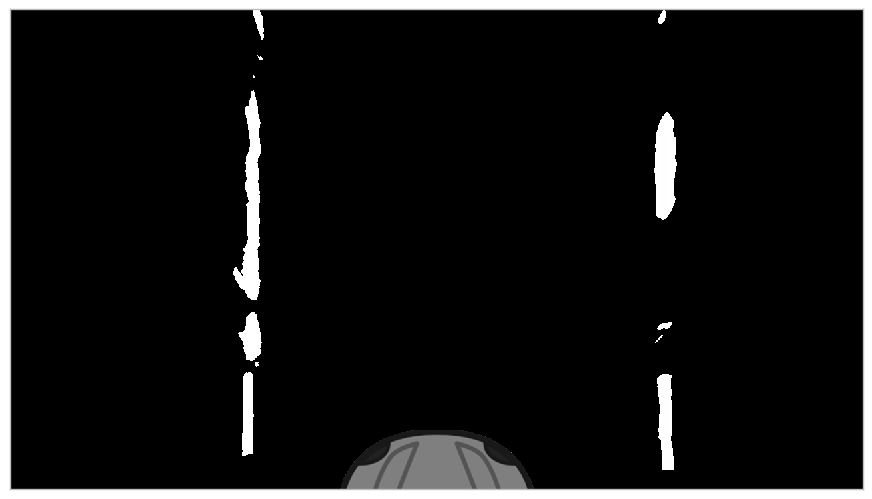

In [29]:
car = cv2.imread('carOverlay.png')
pp = laneFinder.preprocess(frame) * 255
utils.show(cv2.addWeighted(car, 1.0, cv2.merge((pp, pp, pp)), 1.0, 0))

In [30]:
# sobelx = np.abs(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0))
# # Show the effect of the positive dilation.
# self = colorFilter
# s_thresh = self.s_thresh
# sx_thresh = self.sx_thresh
# dilate_kernel = self.dilate_kernel
# dilationIterations = self.dilationIterations
# mask_pos = (sobelx > sx_thresh).astype(np.float32)
# mid = dilate_kernel[1] // 2

# kernel = np.ones(dilate_kernel, np.uint8)
# kernel[:, mid:] = 0
# dmask_pos = cv2.dilate(mask_pos, kernel, iterations=dilationIterations) > 0.

# show(dmask_pos)

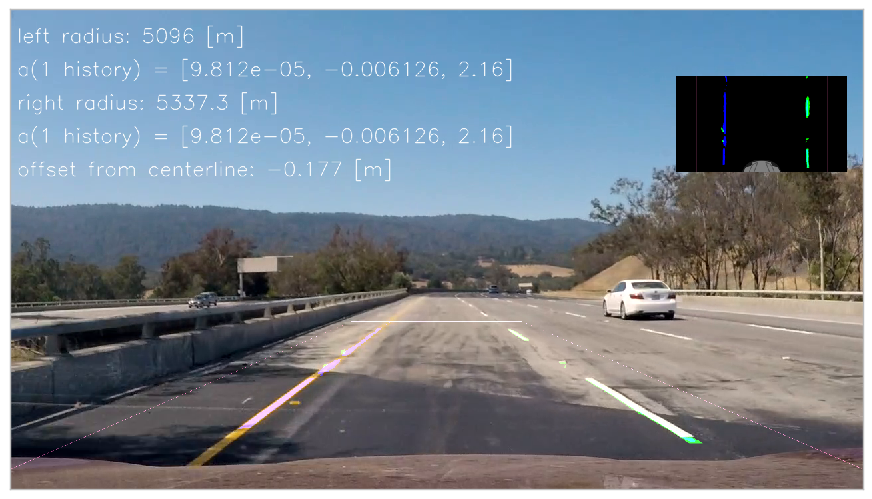

In [31]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort)
laneFinder.colorFilter.dilate_kernel = colorFilter.dilate_kernel
utils.show(laneFinder.draw(frame, showTrapezoid=True, showLane=False, showCentroids=False, insetBEV=True, showCurves=False));

# fig, ax = plt.subplots(figsize=(9, 16))
# laneFinder.show(frame, axes=[ax]);